In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import GridSearchCV

In [2]:
def lognoramlize_data(df:pd.DataFrame)->pd.DataFrame:
  
  """
  This function's purpose is to lognormalize the data set

  Returns:
      Pandas a DataFrame
  """
  df["total_rooms"] = np.log(df["total_rooms"]+1)
  df["total_bedrooms"] = np.log(df["total_bedrooms"]+1)
  df["population"] = np.log(df["population"]+1)
  df["households"] = np.log(df["households"]+1)
  
  return df

def household_feature_creation(df:pd.DataFrame)->pd.DataFrame:
  """This function will create new columns for futher data exploration

  Args:
      Takes in a pandas Dataframe

  Returns:
      pd.DataFrame:
  """
  
  df["bedroom_ratio"] = df["total_bedrooms"]/ df["total_rooms"]
  df["household_rooms"] = df["total_rooms"] / df["households"]
  
  return df

def create_test_train_split(df:pd.DataFrame)->pd.DataFrame:
  """Created Test and Train Splits

  Args:
      Takes in pd.DataFrame

  Returns:
      4 pd.DataFrame's: train_data, Y_train, X_test, Y_test
  """
  df = lognoramlize_data(df)
  df = household_feature_creation(df)
  df = df.join(pd.get_dummies(df.ocean_proximity)).drop(["ocean_proximity"], axis =1)
  X = df.drop(["median_house_value"], axis=1)
  Y = df["median_house_value"]
  X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
  return  X_train.join(Y_train), X_test, Y_train, Y_test

In [3]:
df = pd.read_csv("housing.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df.dropna(inplace =True)

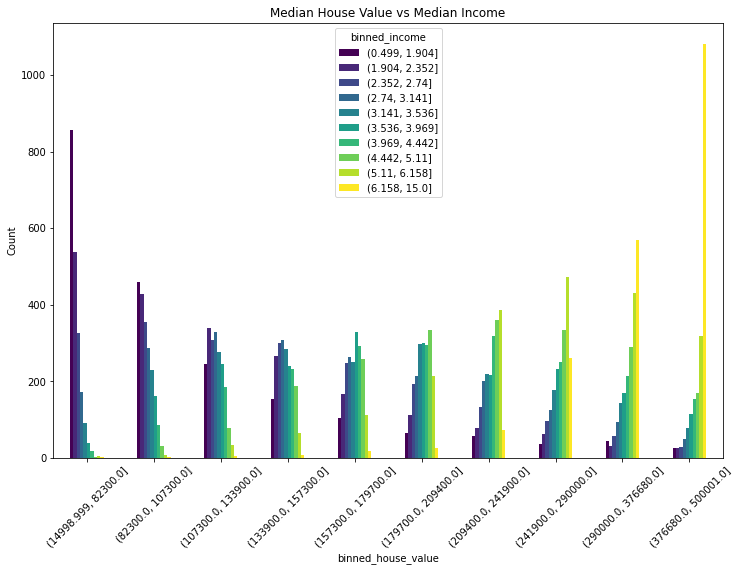

In [6]:
df['binned_income'] = pd.qcut(df['median_income'], 10)  # 10 income bins
df['binned_house_value'] = pd.qcut(df['median_house_value'], 10)  # 10 house value bins

ctab = pd.crosstab(df['binned_house_value'], df['binned_income'])
ctab.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')
plt.title("Median House Value vs Median Income")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [7]:
df.drop(["binned_house_value","binned_income"], inplace=True, axis=1)

In [8]:

data, Y_train, X_test, Y_test= create_test_train_split(df)


In [9]:
scaler = StandardScaler()
X_train, Y_train = data.drop(["median_house_value"], axis =1), data["median_house_value"]
X_train_s = scaler.fit_transform(X_train)

reg = LinearRegression()
reg.fit(X_train_s, Y_train)

LinearRegression()

In [10]:
X_test, Y_test = data.drop(["median_house_value"], axis =1), data["median_house_value"]
X_test_s = scaler.transform(X_test)
reg.score(X_test_s, Y_test)

0.6714614945368831

In [11]:
forest = RandomForestRegressor()

forest.fit(X_train_s, Y_train)

RandomForestRegressor()

In [12]:
forest.score(X_test_s,Y_test)

0.9741783210714227

In [13]:
param_grid = {
  "n_estimators":[3,10,30],
  "max_features": [2,4,6,8]
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(X_train_s, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [14]:
best_forest = grid_search.best_estimator_

In [15]:
best_forest.score(X_test_s, Y_test)

0.9707688725259408

<Axes: >

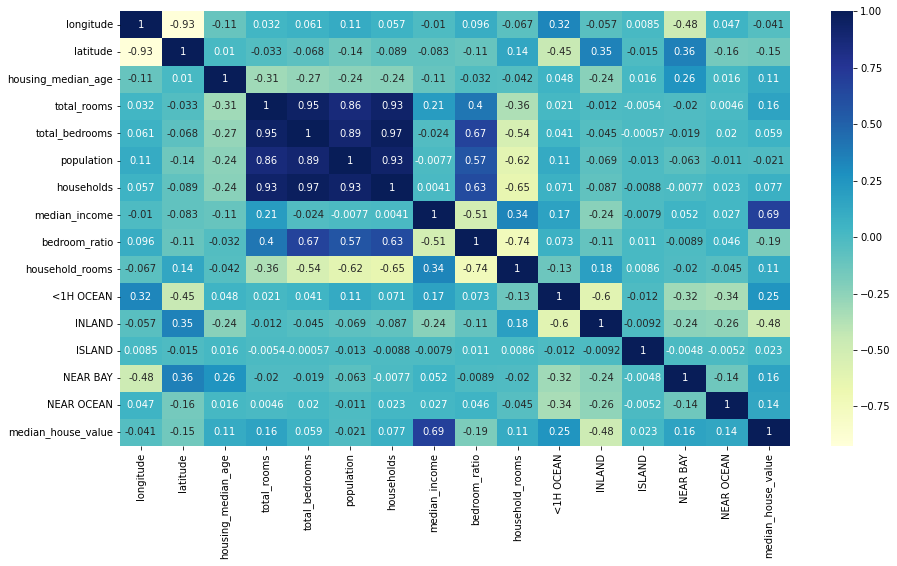

In [16]:
plt.figure(figsize= (15,8))
sns.heatmap(data.corr(), annot=True, cmap="YlGnBu")

<Axes: xlabel='latitude', ylabel='longitude'>

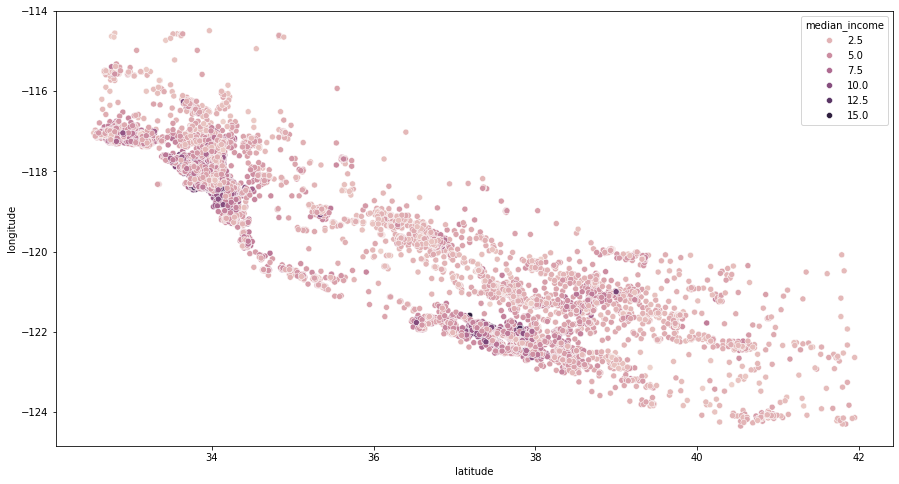

In [17]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="latitude", y ="longitude", data = data, hue ="median_income")